In [1]:
# Set local python and nltk paths
import sys
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python2.7/site-packages')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python2.7/site-packages/IPython/extensions')
sys.path

['/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python2.7/site-packages/IPython/extensions',
 '/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg',
 '/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python2.7/site-packages',
 '',
 '/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python27.zip',
 '/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python2.7',
 '/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python2.7/plat-linux2',
 '/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python2.7/lib-tk',
 '/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python2.7/lib-old',
 '/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python2.7/lib-dynload',
 '/homes/ag6516/.local/lib/python2.7/site-packages',
 '/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python2.7/site-packages',
 '/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python

In [2]:
%matplotlib inline

import os
import csv
import json
import pickle
import pandas as pd
import math

import sklearn
from sklearn import model_selection
from sklearn.decomposition import PCA
import numpy as np
import skimage.transform
from skimage.transform import resize
import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from random import randint
random.seed(123)
np.random.seed(123)

from PIL import Image

import tensorflow as tf

In [3]:
dir = ('/vol/medic02/users/ag6516/x_ray_fracture_localisation/')
# dir = ('/Users/Aydan/PhD/x_ray_fracture_localisation/')
df = pd.read_csv(dir + 'cleaned_reports_edited.csv')

In [4]:
exam_ids = []
for folder in os.listdir(dir+'data/Images'):
    exam_ids.append(str(folder))
    
print len(exam_ids)

330


In [5]:
hs = []
ws = []
for folder in os.listdir(dir+'data/Images'):
    for image in os.listdir(dir+'data/Images/' + folder):
        if image.endswith('.jpg'):
            im = plt.imread(dir+'data/Images/' + folder + '/' + image)
            h,w,c = im.shape
            hs.append(h)
            ws.append(w)

In [6]:
print min(hs)
print max(hs)
print min(ws)
print max(ws)

420
3056
650
3056


In [7]:
sample_images = []
views = {}
for eid in exam_ids:
    for image in os.listdir(dir + 'data/Images/' + str(eid)):
        if image.endswith('.jpg'):
            item = {}
            imid = os.path.splitext(image)[0] 
            item['exam id'] = eid
            item['impath'] = eid + '/' + image
            if '_' in image and os.path.exists(dir + 'data/Images/' + str(eid) + '/' + 'SSImages_BB' + '/' + 'ss_' + image):             
                leg = imid.split('_')[-1]
                
                if leg != 'B':
                    view = imid.split('_')[-2]

                    item['imid'] = imid #.split('_')[0]
                    item['leg'] = leg
                    item['view'] = view
                    if view not in views.keys():
                        views[view] = 0
                    views[view] = views[view] + 1

                    f_ = open(dir + 'data/Images/' + str(eid) + '/' + 'SSImages_BB' + '/'  + image + '.txt', 'r')
                    item['bbox'] = f_.readlines()[1].rstrip('\n').split(' ')
                else:
                    continue
            
            else:
                continue


            sample_images.append(item)
print views
print len(sample_images)

{'HBL': 12, 'WBAP': 25, 'L': 90, 'AP': 61, 'S': 26, 'WBL': 17}
231


In [8]:
train, test = model_selection.train_test_split(sample_images, train_size=0.8, random_state=42)

print len(train), len(test)

184 47


/vol/medic02/users/ag6516/miniconda/envs/TensorFlowCPU/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
# Resize, pad, downsample, adjust bounding box coordinates

def prep_image(im, bbox, ds=1):
    im = np.array(im)
    h, w, _ = im.shape
    max_value = np.max(im)

    if w >= h:
        # resize
        basewidth = 256
        wpercent = (basewidth / float(w))
        hsize = int((float(h) * float(wpercent)))
        #print 'Before: ', im.shape
        im = resize(im, (hsize, basewidth))
        #print 'After resize: ', im.shape
        bbox = bbox*wpercent
        
        # pad
        p = int(math.floor(abs(hsize-256)/2))
        im = np.pad(im, ((p,256-hsize-p), (0,0), (0,0)),'constant', constant_values=(max_value, max_value))
        
        #print 'After padding: ', im.shape 
        #adjust bbox coordinates
        #bbox[0] = bbox[0] + p
        bbox[1] = bbox[1] - (hsize-256)/2
        #bbox[2] = bbox[2] + p
        bbox[3] = bbox[3] - (hsize-256)/2

            
    elif h > w:
        # resize
        baseheight = 256
        hpercent = (baseheight / float(h))
        wsize = int((float(w) * float(hpercent)))
        #print 'Before: ', im.shape
        im = resize(im, (baseheight, wsize))
        #print 'After resize: ', im.shape
        bbox = bbox*hpercent
        
        # pad
        p = int(math.floor(abs(wsize-256)/2))
        im = np.pad(im, ((0,0), (p,256-wsize-p), (0,0)),'constant', constant_values=(max_value, max_value))

        #print 'After padding: ', im.shape    
        # adjust bbox coordinates
        bbox[0] = bbox[0] - (wsize-256)/2
        #bbox[1] = bbox[1] + p
        bbox[2] = bbox[2] - (wsize-256)/2
        #bbox[3] = bbox[3] + p

    # Downsample
    im = resize(im, (im.shape[0] / ds, im.shape[1] / ds))
    bbox = bbox*1/ds

    bbox = [int(i) for i in bbox]
    
    return im, bbox

In [13]:
def next_batch(data, batch_size=100, display_images = False):
    batch = random.sample(data, batch_size)
    images = []
    bboxes = []
    for i in batch:
        if display_images:
            plt.figure()
        
        path = dir + 'data/Images/' + str(i['exam id']) + '/' + 'SSImages_BB' + '/'  + 'ss_' + i['imid'] + '.jpg'
        im = plt.imread(path)
        bbox = np.asarray(i['bbox'], dtype=int)
        
        if display_images:
            #print 'Original: ', im.shape, 'Original bbox: ', i['bbox']
            plt.subplot(1,2,1).set_title('Org. bbox: ' + str(bbox))
            plt.subplot(1,2,1).imshow(im)
            rect1 = patches.Rectangle((bbox[0],bbox[1]),abs(bbox[2]-bbox[0]),abs(bbox[3]-bbox[1]),linewidth=1,edgecolor='r',facecolor='none')
            plt.subplot(1,2,1).add_patch(rect1)
        
        im, bbox = prep_image(im, bbox, ds=4)
        images.append(im)
        bboxes.append(bbox)
        
        if display_images:
            #print 'Cropped: ', im.shape, 'Adjusted bbox: ', bbox
            plt.subplot(1,2,2).set_title('Adj. bbox: ' + str(bbox))
            plt.subplot(1,2,2).imshow(im)
            rect2 = patches.Rectangle((bbox[0],bbox[1]),abs(bbox[2]-bbox[0]),abs(bbox[3]-bbox[1]),linewidth=1,edgecolor='r',facecolor='none')
            plt.subplot(1,2,2).add_patch(rect2)
    
    return np.array(images), np.array(bboxes)

(1, 64, 64, 3)


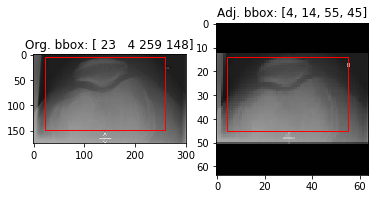

In [14]:
images, bboxes = next_batch(train, batch_size=1, display_images=True)
print images.shape

## Linear regression model

In [ ]:
x = tf.placeholder(tf.float32, shape=[None, 256*256*3])
y_ = tf.placeholder(tf.float32, shape=[None, 4])

W = tf.Variable(tf.zeros([256*256*3,4]))
b = tf.Variable(tf.zeros([4]))

y = tf.matmul(x,W) + b

loss = tf.reduce_mean(tf.losses.mean_squared_error(y_, y))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

In [ ]:
BS = 20
print_y = tf.Print(y,[y])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(100):
        ims, bbs = next_batch(train, batch_size=BS)
        ims_array = np.array(ims)
        ims = np.reshape(ims_array, [BS, 256*256*3])
        train_step.run(feed_dict={x: ims, y_: bbs})
        if i%10==0:
            print loss.eval(feed_dict={x: ims, y_: bbs})

## CNN regression model

In [15]:
#n_input  = 256*256*3
n_output = 4

def conv_simple(_input):
    # Convolutional Layer #1
    _conv1 = tf.layers.conv2d(
        inputs=_input,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    _pool1 = tf.layers.max_pooling2d(inputs=_conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    _conv2 = tf.layers.conv2d(
        inputs=_pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    _pool2 = tf.layers.max_pooling2d(inputs=_conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    #_pool2_flat = tf.reshape(_pool2, [-1, 5242880])
    
    _pool2_flat = tf.reshape(
        _pool2,
        [-1, _pool2.get_shape().as_list()[1] *
         _pool2.get_shape().as_list()[2] *
         _pool2.get_shape().as_list()[3]])

    #_pool1_flat = tf.reshape(_pool1, [-1, 524288])
    
    _dense = tf.layers.dense(inputs=_pool2_flat, units=1024)#, activation=tf.nn.relu)

    # Output Layer
    _out = tf.layers.dense(inputs=_dense, units=4)
    
    # Return everything
    out = {
        #'input': _input, 'conv1': _conv1, 'conv2': _conv2, 
        #'pool1': _pool1,
        #'pool2': _pool2, 
        #'dense': _dense, 
        'out': _out
    }
    return out

In [16]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, 64, 64, 3])
y = tf.placeholder(tf.float32, [None, n_output])

# Parameters
learning_rate   = 0.0001
training_epochs = 100
batch_size      = 20
display_step    = 10

# Functions

_pred = conv_simple(x)['out']
cost = tf.reduce_mean(tf.losses.mean_squared_error(y, _pred))
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
#_corr = tf.equal(tf.argmax(_pred,1), tf.argmax(y,1)) # Count corrects
#accr = tf.reduce_mean(tf.cast(_corr, tf.float32)) # Accuracy
#init = tf.initialize_all_variables()

# Saver 
#save_step = 10;
#savedir = "nets/"
#saver = tf.train.Saver(max_to_keep=3) 

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())    
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(train)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = next_batch(train, batch_size)
            # Fit training using batch data
            sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
            # Compute average loss
            avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch

        # Display logs per epoch step
        if epoch % display_step == 0: 
            print ("Epoch: %03d/%03d cost: %.9f" % (epoch, training_epochs, avg_cost))
            #train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
            print (" Training cost: %.3f" % (avg_cost))
            testimgs, testbboxs = next_batch(test, batch_size=47)
            test_cost = sess.run(cost, feed_dict={x: testimgs, y: testbboxs})
            print (" Test cost: %.3f" % (test_cost))

        # Save Net
        if epoch % save_step == 0:
            saver.save(sess, "nets/cnn_bboxes_simple.ckpt-" + str(epoch))

In [ ]:
# tf Graph input
#x = tf.placeholder(tf.float32, [None, 64, 64, 3])
#y = tf.placeholder(tf.float32, [None, n_output])

#tf.reset_default_graph()
new_saver = tf.train.Saver() 

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    # Restore variables from disk.
    #new_saver = tf.train.import_meta_graph('nets/cnn_bboxes_simple.ckpt-999.meta')
    new_saver.restore(sess, "nets/cnn_bboxes_simple.ckpt-999")    
    print("Model restored.")
    #graph = tf.get_default_graph()
    # Check the values of the variables
    testimgs, testbboxs = next_batch(test, batch_size=47)
    test_cost = sess.run(cost, feed_dict={x: testimgs, y: testbboxs})
    print test_cost
    pred_bboxes = sess.run(_pred, feed_dict={x: testimgs, y: testbboxs})
    print pred_bboxes


In [ ]:
print len(sample_images)

In [63]:
def extract_bboxes(ds=4, display_images = False):

    new_saver = tf.train.Saver() 
    with tf.Session() as sess:
        
        # Restore variables from disk.
        new_saver.restore(sess, "nets/64x64/cnn_bboxes_simple.ckpt-999")    
        print("Model restored.")
        counter=0
        for eid in exam_ids:
            counter = counter+1
            print counter
            if counter==2:
                break
            for image in os.listdir(dir + 'data/Images/' + str(eid)):
                if image.endswith('.jpg'):
                    im = plt.imread(dir + 'data/Images/' + str(eid) + '/' + image)
                    im = np.array(im)
                    h, w, _ = im.shape
                    max_value = np.max(im)

                    if w >= h:
                        # resize
                        basewidth = 256
                        wpercent = (basewidth / float(w))
                        hsize = int((float(h) * float(wpercent)))
                        #print 'Before: ', im.shape
                        im = resize(im, (hsize, basewidth))
                        #print 'After resize: ', im.shape

                        # pad
                        p = int(math.floor(abs(hsize-256)/2))
                        im = np.pad(im, ((p,256-hsize-p), (0,0), (0,0)),'constant', constant_values=(max_value, max_value))

                    elif h > w:
                        # resize
                        baseheight = 256
                        hpercent = (baseheight / float(h))
                        wsize = int((float(w) * float(hpercent)))
                        #print 'Before: ', im.shape
                        im = resize(im, (baseheight, wsize))
                        #print 'After resize: ', im.shape

                        # pad
                        p = int(math.floor(abs(wsize-256)/2))
                        im = np.pad(im, ((0,0), (p,256-wsize-p), (0,0)),'constant', constant_values=(max_value, max_value))

                    # Downsample
                    im = resize(im, (im.shape[0] / ds, im.shape[1] / ds))
                    im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
                    
                    pred_bbox = sess.run(_pred, feed_dict={x: im})
                    pred_bbox = [int(i) for i in pred_bbox[0]]
                    # print pred_bbox
                    up_bbox = = pred_bbox*ds 
                    
                    if display_images:
                        plt.figure()
                        #print 'Original: ', im.shape, 'Original bbox: ', i['bbox']
                        im = im.reshape((im.shape[1], im.shape[2], im.shape[3]))
                        plt.subplot(1,2,1).set_title('Org. bbox: ' + str(pred_bbox))
                        plt.subplot(1,2,1).imshow(im)
                        rect1 = patches.Rectangle((pred_bbox[0],pred_bbox[1]),
                                                  abs(pred_bbox[2]-pred_bbox[0]),
                                                  abs(pred_bbox[3]-pred_bbox[1]),linewidth=1,
                                                  edgecolor='r',facecolor='none')
                        plt.subplot(1,2,1).add_patch(rect1)

INFO:tensorflow:Restoring parameters from nets/64x64/cnn_bboxes_simple.ckpt-999
Model restored.
1
[18, 6, 37, 23]
[9, 22, 43, 44]
[13, 12, 48, 55]
[2, 6, 47, 49]
[13, 7, 55, 54]
[8, 7, 42, 51]
2


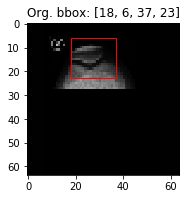

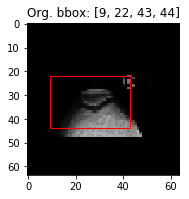

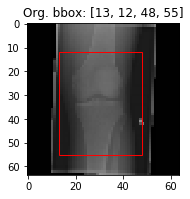

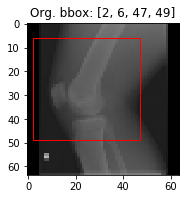

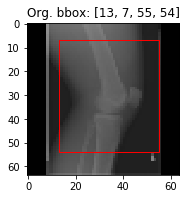

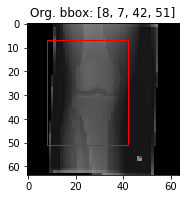

In [64]:
extract_bboxes(display_images=True)